# A/B test о длительности сессии

In [2]:
import pandas as pd
import numpy as np

Мы сотрудники компании X (twitter) и работаем над улучшением рекомендательной системы. Возникает вопроc какие твиты показывать пользователю, чтобы ему было максимально интересно. Проанализируем сколько времени пользователь проводит в приложении или на сайте, когда туда заходит. Основываясь на этом, хотим улучшить рекомендательную систему.

# Анализ исходных данных

Сгенерируем Данные по длине пользовательских сессий (в секундах) с помощью логнормального распределения.

In [3]:
df = pd.DataFrame({'session_len':np.random.lognormal(6,0.8,size=20000)})

In [4]:
df.head()

,session_len
0,718.153787
1,1003.652306
2,1210.968426
3,214.429843
4,77.135035


<Axes: >

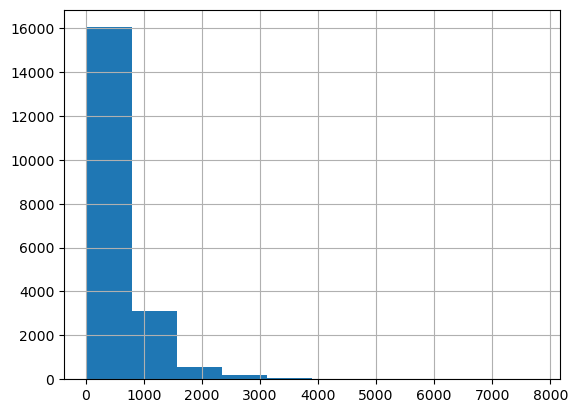

In [5]:
df['session_len'].hist()

In [6]:
df['session_len'].mean()

550.451977515545

В среднем пользовательская сессия длится 550 секунд или около 9 минут. Видим, что в основном сессии короткие, но бывают и достаточно длинные.

# Гипотезы

Мы хотим протестировать изменение в рекомендательном алгоритме. Пусть мы придумали кое-какое нововведение, которое по нашему мнению должно сделать ленту более интересной, и, следовательно, время сессии увеличится.

Подобного рода гипотезы проверяются с помощью А/Б теста с контрольной и тестовой группой.

Будет две группы:
- Контрольная (А): в этой группе пользователи будут видеть старые рекомендации
- Тестовая (Б): в этой группе пользователи будет видеть новые рекомендации.

Формулируем нулевую и альтернативную гипотезы:
- H0: средняя длина пользовательской сессии в группе А и в группе Б равны
- H1: средняя длина пользовательской сессии в группе А и в группе Б не равны

Альтернативная гипотеза выбрана двухсторонняя, так как в данном случае нас так же интересуют отклонение средней длительности как вниз, так и вверх.

# Требования к тесту

Решим какие минимальный эффект, мощность и альфу (значимость) мы хотим получить для этого теста.

Предположим, что нам интересно отслеживать изменение длины пользовательской сессии минимум на 1 минуту или на 60 секунд. Данных у нас в X много, поэтому мы вполне можем позволить себе мощность 90% и альфу 1%.

Хотим чтобы тест:
- мог обнаружить изменение пользовательской сессии минимум на 60 секунд (MDE)
- имел мощность в 90% (Sensivity), т.е. обнаруживал наличие отклонения в 90% случаев, когда оно действительно есть
- имел альфу 1% (Significance), т.е. обнаруживал наличие отклонения только  в 1% случаев, когда отклонения на самом деле нет. 

Длина пользовательской сессии – это непрерывная переменная, поэтому здесь мы будем использовать t test для рассчета p-value.

## Нормальность выборочного среднего

Требование для t-test: выборочное среднее должно быть распределено нормально. Проверим это.

У нас есть выборка в 20000 сессий. С помощью бутстрепа посмотрим, как будет распределено выборочное среднее при таком размере выборке.

In [9]:
result = []
for i in range(1000):
    result.append(df['session_len'].sample(frac=1, replace=True, random_state=i).mean())
t = pd.DataFrame({'sample_mean':result})

Посмотрим на гистограмму.

<Axes: >

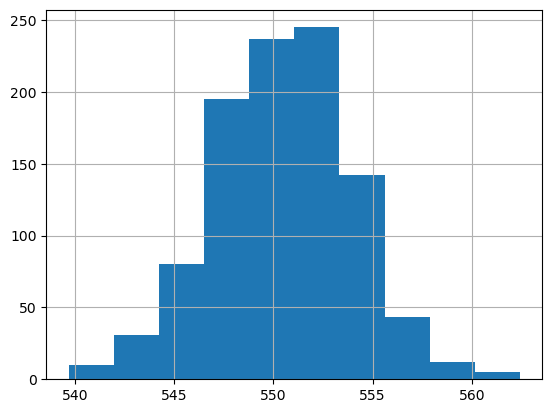

In [10]:
t['sample_mean'].hist()

Кажется, что распределение вполне нормальное. Подтвердим это еще одним графиком графиком.

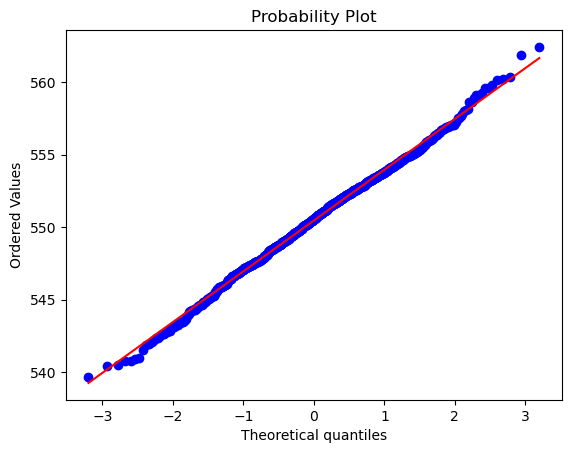

In [11]:
import pylab
import scipy.stats as stats

stats.probplot(t['sample_mean'], dist="norm", plot=pylab)
pylab.show()

Да, распределение вполне можно считать нормальным.

## Проверка соответствия реального FPR желаемому

Рассмотрим, соответствует ли альфа реальной вероятности ошибки первого рода. Для этого нам потребуется сам t-test (для двух выборок).

In [12]:
from scipy.stats import ttest_ind

In [13]:
a = df['session_len'].sample(frac=1,replace=True,random_state=0)

In [14]:
b = df['session_len'].sample(frac=1,replace=True,random_state=1)

In [15]:
ttest_ind(a,b,equal_var=False,alternative='two-sided')

TtestResult(statistic=0.2690525335269282, pvalue=0.7878906456252137, df=39963.71789698123)

Теперь проверим, соответствует ли альфа реальной вероятности ошибки первого рода (fpr). Для этого будем генерировать подвыборки из исходной выборки и считать для них p-value.

In [16]:
n = 1000
result = []
for i in range(n):
    a = df['session_len'].sample(frac=1,replace=True,random_state=i)
    b = df['session_len'].sample(frac=1,replace=True,random_state=n-i)
    pvalue = ttest_ind(a,b,equal_var=False,alternative='two-sided')[1]
    result.append((a.mean(),b.mean(),abs(a.mean() - b.mean()),pvalue))

In [18]:
t = pd.DataFrame(result,columns=['a_mean','b_mean','diff_abs','p-value'])
t

,a_mean,b_mean,diff_abs,p-value
0,552.210738,546.241618,5.969120,0.248652
1,550.836881,547.598755,3.238125,0.520795
2,547.081942,545.028197,2.053745,0.678381
3,547.737499,549.177410,1.439912,0.773628
4,549.737839,548.959814,0.778024,0.879558
...,...,...,...,...
995,552.581660,550.430360,2.151300,0.670567
996,548.959814,549.737839,0.778024,0.879558
997,549.177410,547.737499,1.439912,0.773628
998,545.028197,547.081942,2.053745,0.678381


Столбцы в этой таблице:
- средняя длина сессии в контрольной группе
- средняя длина сессии в тестовой группе
- разница между двумя средними по модулю
- p-value: вероятность получить минимум такое различие между средними при условии, что среднее в контрольной и тестовой группе равны

Отвергнем нулевую гипотезу с альфой равной 1%, и посмотрим какую долю ошибок первого рода мы тут допустим: ведь мы знаем, что нулевая гипотеза здесь заведома верна для всех строк.

In [20]:
(t['p-value'] < 0.01).mean()

0.018

Нас это удовлетворяет. Сравним распределение p-value c равномерным распределением.

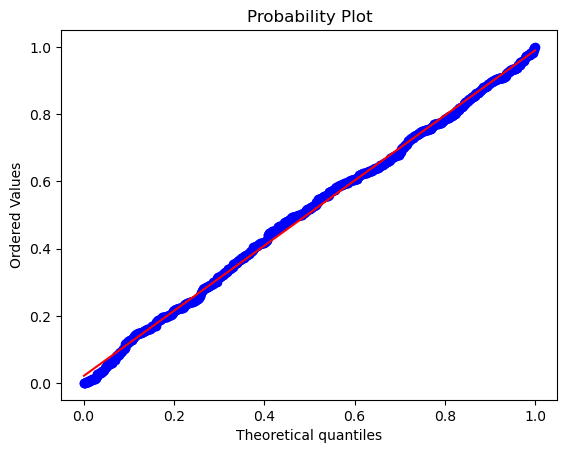

In [22]:
stats.probplot(t['p-value'], dist="uniform", plot=pylab)
pylab.show()

Распределение p-value равномерное, а значит ошибка первого рода всегда будет соответствовать альфе. T-test проверен со всех сторон.

# Расчет размера выборок

Возьмем все параметры и рассчитаем необходимые размеры выборок.

In [24]:
import statsmodels.stats.api as sms

Рассчитаем размер эффекта по формуле: минимальный эффект (минимум 60 секунд) / на стандартное отклонение. 

In [25]:
es = 60 / df['session_len'].std()
es

0.11716871545307542

In [26]:
sms.TTestIndPower().solve_power(es, power=0.90, alpha=0.01, ratio=1, alternative='two-sided')

2169.322185684513

Получилось, что нам нужно всего 2170 наблюдения в каждой группе. А будет ли ти тест давать нормальные результаты при такой маленькой выборке? Посмотрим на распределение p-value для верной нулевой гипотезы при таких выборках.

In [27]:
n = 1000
result = []
for i in range(n):
    a = df['session_len'].sample(2170,replace=True,random_state=i)
    b = df['session_len'].sample(2170,replace=True,random_state=n-i)
    pvalue = ttest_ind(a,b,equal_var=False,alternative='two-sided')[1]
    result.append((a.mean(),b.mean(),abs(a.mean() - b.mean()),pvalue))

In [28]:
t = pd.DataFrame(result,columns=['a_mean','b_mean','diff_abs','p-value'])

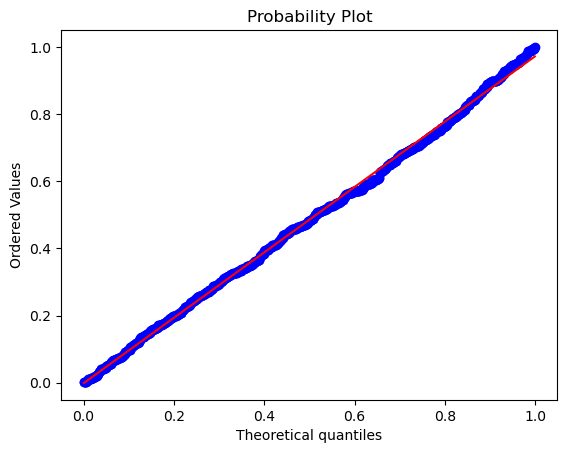

In [29]:
stats.probplot(t['p-value'], dist="uniform", plot=pylab)
pylab.show()

# Проверяем соответствует ли реальный TPR мощности

Будет ли у теста реально мощность 90% при таком размере выборки? Посмотрим на распределение соответствующее альтернативной гипотезе. 

Мы хотим получить распределение со средним, которое больше на 60 секунд. Прибавим 60 к каждому наблюдению в нашей выборке (хотя это грубый трюк)

Вот исходное среднее.

In [30]:
df['session_len'].mean()

550.451977515545

Вот измененное.

In [31]:
(df['session_len'] + 60).mean()

610.451977515545

Посчитаем мощность для распределения альтернативной гипотезы полученного таким образом.

In [33]:
n = 1000
result = []
for i in range(n):
    a = df['session_len'].sample(2170,replace=True,random_state=i)
    b = (df['session_len'] + 60).sample(2170,replace=True,random_state=n-i)
    pvalue = ttest_ind(a,b,equal_var=False,alternative='two-sided')[1]
    result.append((a.mean(),b.mean(),abs(a.mean() - b.mean()),pvalue))

In [34]:
t = pd.DataFrame(result,columns=['a_mean','b_mean','diff_abs','p-value'])

Отвергнем нулевую гипотезу при альфа равной 1% и посчитаем долю отвергнутых нулевых гипотез.

In [35]:
(t['p-value'] < 0.01).mean()

0.891

Мощность соответствует нашим расчетам.


# Увеличиваем значимость

Мы можем себе позволить альфу в 0.1%. Посмотрим размеры выборки при такой альфе.

In [36]:
es = 60 / df['session_len'].std()


In [37]:
sms.TTestIndPower().solve_power(es, power=0.90, alpha=0.001, ratio=1, alternative='two-sided')

3048.034829223486

Размер выборки вырос не сильно. Можем еще уменьшить минимальный эффект и повысить мощность.

In [38]:
es = 30 / df['session_len'].std()
sms.TTestIndPower().solve_power(es, power=0.95, alpha=0.001, ratio=1, alternative='two-sided')


14196.809603033285

Чтобы провести тест с минимальным эффектом в 30 секунд, мощностью 95% и вероятностью ошибки первого рода в 0.1% потребуется 14196 наблюдений как в контрольной, так и в тестовой группе. Поскольку мы работаем в X, то вполне можем позволить себе выборки таких размеров.

# Оценка результатов

Мы провели А/Б тест с высчитанными нами размерами выборок и получил следующие результаты.

Сгенерим контрольную группу.

In [40]:
a = np.random.lognormal(6.01,0.8,size=14200)

Сгенерим тестовую группу.

In [42]:
b = np.random.lognormal(6.09,0.76,size=14200)

Среднее в контрольной группе получилось

In [43]:
a.mean()

560.321721685009

Среднее в тестовой получилось

In [44]:
b.mean()

588.5403293599229

Теперь посчитаем p-value, т.е. вероятность получить минимум такую разницу между группами, при условии, что средние на самом деле равны.

In [45]:
ttest_ind(a,b,equal_var=False,alternative='two-sided')

TtestResult(statistic=-4.55484556930801, pvalue=5.264197532830499e-06, df=28386.720023640493)

Здесь p-value получилось равным 5 * 10 ** -6 – это меньше чем выбранная нами альфа в 0.1% или 0.001. Поэтому отвергаем нулевую гипотезу о том, что группы имеют равное среднее в пользу альтернативной гипотезы: среднее в контрольной группе не равно среднему в тестовой группе.

## Заключение
Делаем вывод, что изменение в рекомендательной системе оказало положительный эффект и мы можем вводить это изменение для всех пользователей.